In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
import math

##for displaying images  
from IPython.display import Image, display,HTML

In [67]:
torch.__version__  # for version check

'0.3.0.post4'

# Mixture of Softmaxes

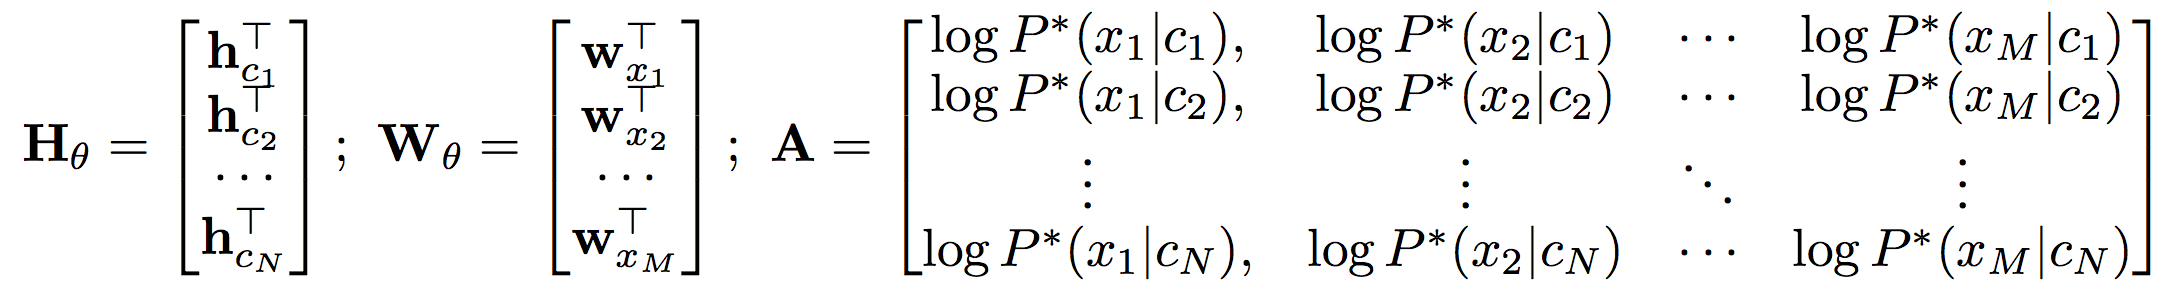

In [68]:
Image('/imgs/mos1.png')

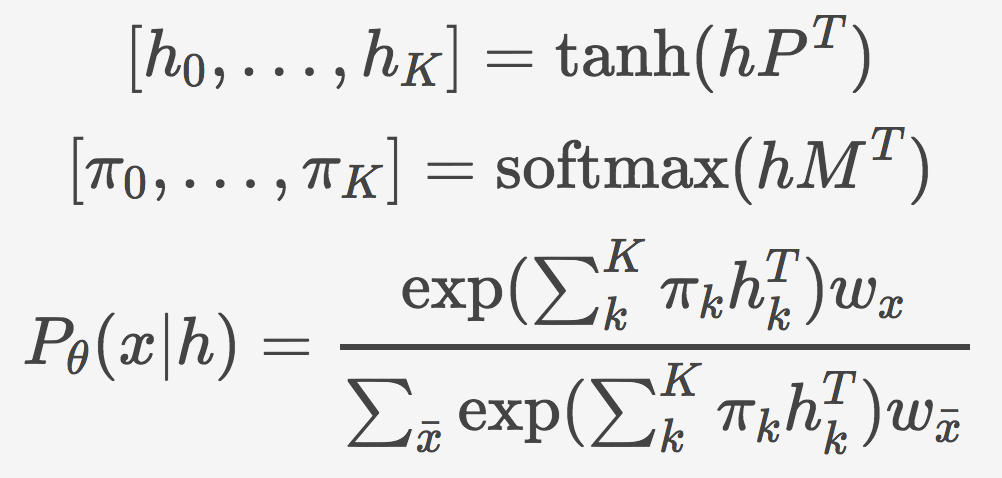

In [69]:
Image('/imgs/mixture_of_softmaxes.png',width=300)

H is context vector dim : Number Of Samples(N) * Embedding Dimension(D) <br>
W is weights            : Number Of classes(M) * Embedding Dimension(D)

A = H* W(T)

Reference: 
1) Paper: BREAKING THE SOFTMAX BOTTLENECK https://arxiv.org/pdf/1711.03953.pdf
2) Blog by Smerity : https://smerity.com/articles/2017/mixture_of_softmaxes.html     

In real life we end up with low rank approximation of  matrix A since rank of A is upper bounded by D while matrix A can achieve full rank V. In this paper they introduce mixture of softmaxes concept to overcome this issue. you can see results below for H=32,V=1000,S=2048.In pyramidnet when alpha=48 then fc dimension will be 64 which will be less than 100



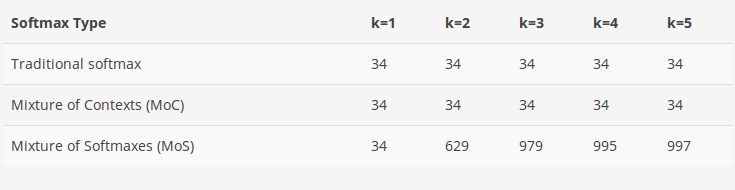

In [70]:
Image('/imgs/mos2.png')


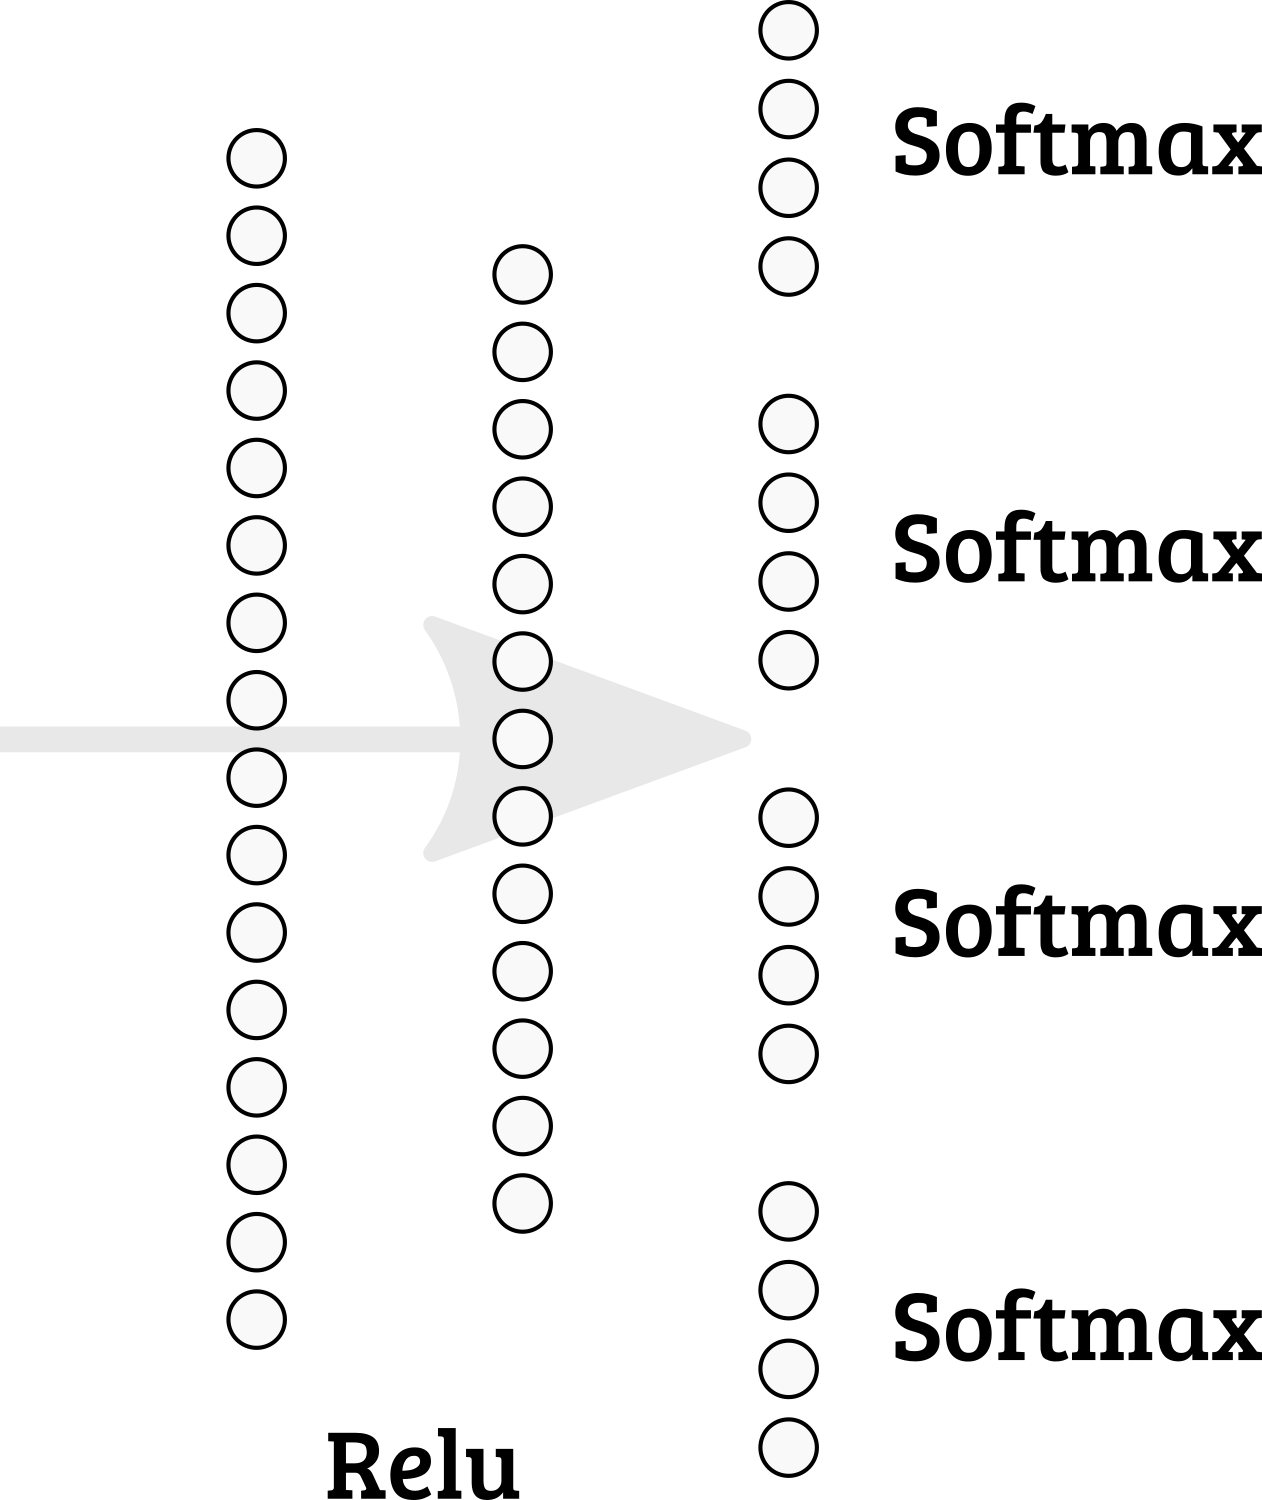

In [71]:
Image('/imgs/mos.png',width=300)

## Recurrent Dropout

Mixture of Softmaxes introuduces large number of parameters due to D * KD matrix multiplication. As shown in the above figure there is huge matrix multiplication and then factorise it into number of expert dimension. Dropout is de-facto technique for regularization nowdays. 

Naive dropout can be problematic here since it might be the case that in some experts matrix there might be lot of empty neuron which can cause problem in stabilizing training procedure. This system is analogus to language modelling since we can consider number of experts as number of time step. 

Idea here is to apply Variation Dropout or Recurrent Dropout which is calcuting mask for only one time-step(expert) and same apply it to all the time step.  



In [72]:
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(x.size(0),1, x.size(2)).bernoulli_(1 - dropout) # for single time-step 
        mask = Variable(m.div_(1 - dropout), requires_grad=False)
        mask = mask.expand_as(x)  # for every time step 
        return mask * x

In [73]:
class mixture_of_softmaxes(torch.nn.Module):

    
    def __init__(self, nhid, n_experts, num_class):

        super(mixture_of_softmaxes, self).__init__()
        
        self.nhid=nhid
        self.num_class=num_class
        self.n_experts=n_experts
        
        self.prior = nn.Linear(nhid, n_experts, bias=False)
        self.latent = nn.Sequential(nn.Linear(nhid, n_experts*nhid), nn.Tanh())
        self.decoder = nn.Linear(nhid, num_class)
        self.rec_drop = LockedDropout()
   
    def forward(self, x):
        
        latent = self.latent(x)    
        
        latent_dropout = self.rec_drop(latent.view(-1, self.n_experts, self.nhid),0.3) # Recurrent Dropout
        logit = self.decoder(latent.view(-1,self.nhid)) 

        prior_logit = self.prior(x)   # calculating weight for the each experts
        prior = nn.functional.softmax(prior_logit)  # normlizing the weights 

        prob = nn.functional.softmax(logit.view(-1, self.num_class)).view(-1, self.n_experts, self.num_class)
        prob = (prob * prior.unsqueeze(2).expand_as(prob)).sum(1)   
        

        return prob

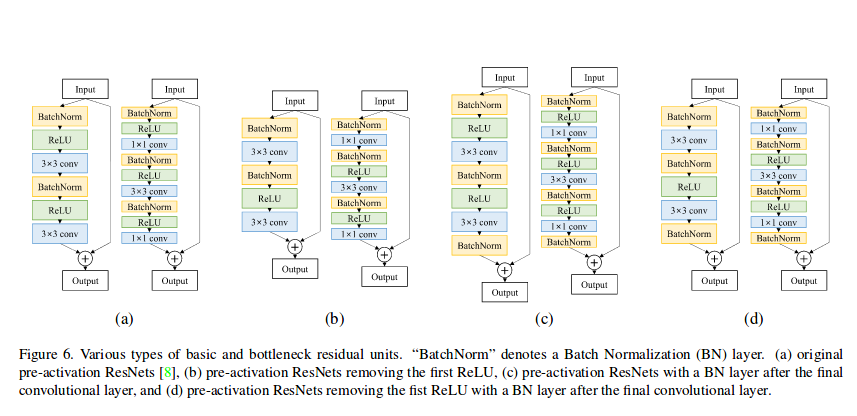

In [74]:
Image('/imgs/basic.png')

In [75]:
class basic(nn.Module):
    
    channel_ratio=1
    
    
    # basic block (c) as shown in above mentioned image in which they remove first relu and put BN layer at the end.
    
    def __init__(self,input_channel, output_channel,stride=1,downsample=None):
        super(basic,self).__init__()
        self.bn1= nn.BatchNorm2d(input_channel)
        self.conv1 = nn.Conv2d(input_channel,output_channel,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2= nn.BatchNorm2d(output_channel)
        self.conv2 = nn.Conv2d(output_channel,output_channel,kernel_size=3,padding=1,bias=False)
        self.bn3= nn.BatchNorm2d(output_channel)
        self.downsample=downsample
        self.stride= stride
    
    def forward (self,x):
        out=self.bn1(x)
        out=self.conv1(out)
        out=F.relu(self.bn2(out)) # might use replace= True for memory optimization 
        out=self.conv2(out)
        out=self.bn3(out)
        
        if self.downsample is not None:
            residual= self.downsample(x)            
        else:
            residual = x # there might not be mismatch in height and width dim i.e in first layer 
        
        # there will be mismatch in number of channel since 
        # first conv of the block will have different input and output channel 
        # author suggested zero padding(can think as combination of regular and residual network) as shown in below image.
        
        
        batch_size,c1,h,w = out.size()    # get the dimesion of input
        c2 = residual.size()[1]           # get the number of channel of output 

        if c1 != c2:
            zero_padding = Variable(torch.zeros((batch_size,c1-c2,h,w)).cuda()) # .cuda() for GPU tensor 
            out += torch.cat((residual,zero_padding),1) # zero padding # concatenation on channel dimension
        else:
            out += residual  # residual connection 
        
        return out

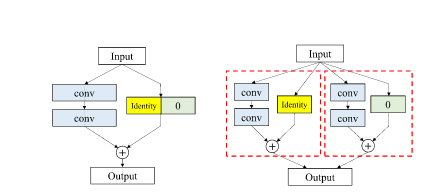

In [76]:
Image('/imgs/Screenshot from 2018-03-20 12-45-34.png',width=2000)

In [77]:
class botteleneck(nn.Module):
    channel_ratio=4   # for dimension mismatch 
    
    
    # botteleneck module is same as except this has 1*1 convolution (like in inception module) 
    # which introduce less parameter and higher non-linearity
    
    def __init__(self,input_channel, output_channel,stride=1,downsample=None):
        super(botteleneck,self).__init__()
        self.bn1= nn.BatchNorm2d(input_channel)
        self.conv1 = nn.Conv2d(input_channel,output_channel,kernel_size=1,bias=False)
        self.bn2= nn.BatchNorm2d(output_channel)
        self.conv2 = nn.Conv2d(output_channel,output_channel,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn3= nn.BatchNorm2d(output_channel)
        self.conv3 = nn.Conv2d(output_channel,output_channel*channel_ratio,kernel_size=1,bias=False)
        self.bn4= nn.BatchNorm2d(output_channel*channel_ratio)
        self.downsample=downsample
        self.stride= stride
    
    def forward (self,x):
        out=self.bn1(x)
        out=self.conv1(out)
        out=F.relu(self.bn2(out))
        out=self.conv2(out)
        out=F.relu(self.bn3(out))
        out=self.conv3(out)
        out=self.bn4(out)
        
        if self.downsample is not None:
            residual= self.downsample(x)           
        else:
            residual = x
        
        batch_size,c1,h,w = out.size()
        c2 = residual.size()[1]
        zero_padding = Variable(torch.zeros((batch_size,c1-c2,h,w)).cuda())
        residual = torch.cat((residual,zero_padding),1)
        
        out += residual 
        
        return out

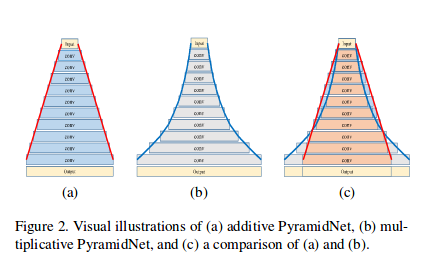

In [78]:
Image('/imgs/pyramidnet.png')

In [79]:
class pyramidnet(nn.Module):
    def __init__(self,block,alpha, depth,mos,num_class,k):
        super(pyramidnet, self).__init__()  
        
        self.input_channel = 16    # number of channel for the first layer
        
        self.mos=mos            # to inculde mixtue of softmaxes layer
        
        num_blocks = (depth-2)/6     
        
        self.add = alpha / (3*num_blocks*1.0)    # addition in number of channel at every conv layer 
                                                 # 0.1 for float divison 
        
        

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        if block == 'basic':          
            block=basic
        else:
            block = botteleneck

        self.l1 = self.make_layer(block,num_blocks)
        self.l2 = self.make_layer(block,num_blocks,stride=2)   # stride=2 to reduce height and width dimension
        self.l3 = self.make_layer(block,num_blocks,stride=2)
        
        self.bn_last = nn.BatchNorm2d(int(round(self.input_channel)))  # int round to make interger since parameter  
                                                                       # should be integer
            
        self.avgpool = nn.AvgPool2d(8)          # average pooling in the last layer 
        
        
        if self.mos:
            self.MOS= mixture_of_softmaxes(int(round(self.input_channel)),k,num_class) # k here is number of experts

        else:
            self.fc = nn.Linear(int(round(self.input_channel)),num_class)
        
        
        # Initilisation as mentioned in original resnet paper 
        # i.e all the conv layer are initilialised with He initilisation 
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_uniform(m.weight, a=math.sqrt(2))
            elif isinstance(m, nn.BatchNorm2d):
                init.constant(m.weight, 1)
                init.constant(m.bias, 0)
                

        
        
    def make_layer(self,block,layer_depth,stride=1):
        
        downsample=None
        
        
        # mismatch in height and width dim due to stride= 2 
        # average pooling is used to reduce dimension 
        if stride != 1 :
            downsample = nn.AvgPool2d((2,2), stride = (2, 2))
        
        layers=[]
        
        self.output_channel= self.input_channel + self.add     # increasing channel dimesnion slowly 
        
        layer1 = block(int(round(self.input_channel)),int(round(self.output_channel)),stride,downsample)  
        layers.append(layer1)
        
        self.input_channel = self.output_channel        # for next layers 
        
        # number of block-1 in one layer
        # block.channel ratio for botteleneck layer 
    
        
        for i in range(1,int(layer_depth)):               
            self.output_channel = self.input_channel + self.add
            layers.append(block(int(round(self.input_channel))*block.channel_ratio,int(round(self.output_channel))))
            self.input_channel= self.output_channel	*block.channel_ratio
        
        return nn.Sequential(*layers) 
    
    def forward(self,x):
        x = self.conv1(x)
        x=  self.bn1(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = F.relu(self.bn_last(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # flattening the features for fully connected network 
        if self.mos:
            x=self.MOS(x)
            x=torch.log(x)         #  output of the mos is the probabilities.we applied NLLloss()
                                   #  which accepts the log probabilites           
        else:
            x = self.fc(x)         # here we applied CrossEntropy loss function which combination of 
                                   # log_softmax() + NLLloss() 
                                   # no need to apply log function 

        
        return x 

In [80]:
pyramidnet('basic',10,12,True,10,2)

pyramidnet(
  (conv1): Conv2d (3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (l1): Sequential(
    (0): basic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (conv1): Conv2d (16, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (18, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (l2): Sequential(
    (0): basic(
      (bn1): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
      (conv1): Conv2d (18, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(20, eps=1e-05, mom